In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Increase the default plot size and set the color scheme
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['image.cmap'] = 'viridis'

# Modeling libraries

from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold,train_test_split
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error,mean_squared_error


from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet, Lasso, Ridge
import xgboost as xgb
import lightgbm as lgb

from bayes_opt import BayesianOptimization


import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

In [2]:
data = pd.read_csv('../data.csv', sep=';')
data.head(25)

,row_num,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id_set,traffic_type,session_durantion,hits
0,988681,L6,Monday,17,1,2111,31672;0,6,7037,\N
1,988680,L2,Thursday,22,10,2113,31965;0,2,49,14
2,988679,L4,Saturday,21,2,2100,0;78464,1,1892,14
3,988678,L3,Saturday,19,8,2113,51462,6,0,1
4,988677,L2,Tuesday,6,10,2116,31931;0,1,2,3
5,988676,L3,Monday,1,8,2100,0,1,0,2
6,988675,L2,Friday,20,10,2166,0,1,0,2
7,988674,L3,Sunday,3,1,2113,34302;0,6,2,3
8,988673,L3,Sunday,1,10,2111,34227;0,6,4,3
9,988672,L6,Sunday,5,9,2113,42172;0;38715,2,724,45


In [3]:
data.describe()

,row_num,hour_of_day,agent_id,entry_page,traffic_type
count,988681.000000,988681.000000,988681.000000,988681.000000,988681.000000
mean,494341.000000,13.203988,7.350779,2253.265114,2.773766
std,285407.765084,6.718056,3.869630,775.083390,1.920976
min,1.000000,0.000000,0.000000,2100.000000,1.000000
25%,247171.000000,8.000000,6.000000,2111.000000,1.000000
50%,494341.000000,14.000000,9.000000,2113.000000,2.000000
75%,741511.000000,19.000000,10.000000,2116.000000,4.000000
max,988681.000000,23.000000,15.000000,8101.000000,10.000000


In [4]:
data.shape

(988681, 10)

### Data Preparation and Cleaning

In [5]:
data.isnull().sum()

row_num                 0
locale                  0
day_of_week             0
hour_of_day             0
agent_id                0
entry_page              0
path_id_set          4889
traffic_type            0
session_durantion       0
hits                    0
dtype: int64

We also need to clear a bit our dataset, for instance column `session_duration` contains some '\N' values, let us simply drop them since their amount is pretty negligible.

In [6]:
data = data[data.session_durantion != '\\N']
data.shape

(988013, 10)

We will need it when we going to use CatBoost, since the data preparation and feature engineering are slightly differ.

In [7]:
data_cat = data.copy()

We also need to change the type of a few columns.

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 988013 entries, 0 to 988680
Data columns (total 10 columns):
row_num              988013 non-null int64
locale               988013 non-null object
day_of_week          988013 non-null object
hour_of_day          988013 non-null int64
agent_id             988013 non-null int64
entry_page           988013 non-null int64
path_id_set          983124 non-null object
traffic_type         988013 non-null int64
session_durantion    988013 non-null object
hits                 988013 non-null object
dtypes: int64(5), object(5)
memory usage: 82.9+ MB


In [9]:
# Start with session duration and transform from object to int
data.session_durantion =  data.session_durantion.astype(int)

Let's separate train and test subsets of data

In [10]:
mask = data['hits'] == '\\N'
train_data = data[~mask]
test_data = data[mask]

In [11]:
train_data.shape

(618821, 10)

In [12]:
test_data.shape

(369192, 10)

In [13]:
train_data.head(10)

,row_num,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id_set,traffic_type,session_durantion,hits
1,988680,L2,Thursday,22,10,2113,31965;0,2,49,14
2,988679,L4,Saturday,21,2,2100,0;78464,1,1892,14
3,988678,L3,Saturday,19,8,2113,51462,6,0,1
4,988677,L2,Tuesday,6,10,2116,31931;0,1,2,3
5,988676,L3,Monday,1,8,2100,0,1,0,2
6,988675,L2,Friday,20,10,2166,0,1,0,2
7,988674,L3,Sunday,3,1,2113,34302;0,6,2,3
8,988673,L3,Sunday,1,10,2111,34227;0,6,4,3
9,988672,L6,Sunday,5,9,2113,42172;0;38715,2,724,45
10,988671,L6,Wednesday,15,8,2100,0;45069;44232,1,896,39


In [14]:
test_data.head(10)

,row_num,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id_set,traffic_type,session_durantion,hits
0,988681,L6,Monday,17,1,2111,31672;0,6,7037,\N
15,988666,L3,Thursday,16,10,2700,0;34387;84765,1,5189,\N
16,988665,L4,Sunday,16,10,2113,79148;0,4,5,\N
17,988664,L3,Tuesday,19,6,2100,0;34602;34604,1,8041,\N
18,988663,L3,Friday,20,10,2111,34287;0;60579,2,117,\N
20,988661,L2,Friday,19,10,2113,46575;0,2,80,\N
21,988660,L2,Thursday,20,1,2111,31467;0,2,26,\N
26,988655,L3,Thursday,20,6,2100,0;34984;34421;34415;34998,3,1721,\N
27,988654,L6,Saturday,15,6,2100,0;95235,1,44,\N
34,988647,L4,Tuesday,6,10,2116,78573;0,2,1494,\N


Now we need to drop `row_num` column for the training set since it does not really helpful; but for the test set, we will save it separately, because we will need it for submission.

In [15]:
train_data = train_data.drop('row_num', axis = 1)
row_number_test = test_data['row_num']
test_data = test_data.drop('row_num', axis = 1)

Now it is time to change the type of target variable `hits` from object to int.

In [16]:
train_data.hits = train_data.hits.astype('int64');

In [17]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 618821 entries, 1 to 988680
Data columns (total 9 columns):
locale               618821 non-null object
day_of_week          618821 non-null object
hour_of_day          618821 non-null int64
agent_id             618821 non-null int64
entry_page           618821 non-null int64
path_id_set          615668 non-null object
traffic_type         618821 non-null int64
session_durantion    618821 non-null int64
hits                 618821 non-null int64
dtypes: int64(6), object(3)
memory usage: 47.2+ MB


In [18]:
test_data = test_data.drop('hits', axis = 1)
test_data.head(15)

,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id_set,traffic_type,session_durantion
0,L6,Monday,17,1,2111,31672;0,6,7037
15,L3,Thursday,16,10,2700,0;34387;84765,1,5189
16,L4,Sunday,16,10,2113,79148;0,4,5
17,L3,Tuesday,19,6,2100,0;34602;34604,1,8041
18,L3,Friday,20,10,2111,34287;0;60579,2,117
20,L2,Friday,19,10,2113,46575;0,2,80
21,L2,Thursday,20,1,2111,31467;0,2,26
26,L3,Thursday,20,6,2100,0;34984;34421;34415;34998,3,1721
27,L6,Saturday,15,6,2100,0;95235,1,44
34,L4,Tuesday,6,10,2116,78573;0,2,1494


In [19]:
# Data shape
print('Train data and Test data size {}{}'.format(train_data.shape, test_data.shape))

Train data and Test data size (618821, 9)(369192, 8)


### Simple EDA

Text(0, 0.5, 'Number of hits')

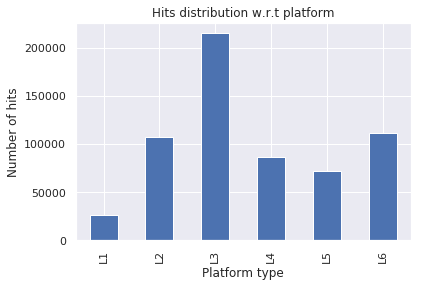

In [20]:
# The platform of the session
train_data.groupby('locale')['hits'].count().plot(kind='bar')

plt.title('Hits distribution w.r.t platform')
plt.xlabel('Platform type')
plt.ylabel('Number of hits')

Text(0, 0.5, 'Number of hits')

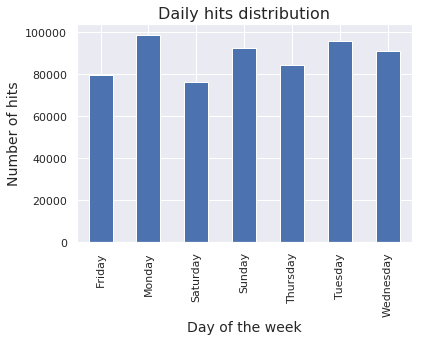

In [21]:
# Day of the week

train_data.groupby('day_of_week')['hits'].count().plot(kind='bar')
plt.xticks(rotation='vertical')
plt.title('Daily hits distribution', fontsize = 16)
plt.xlabel('Day of the week', fontsize = 14)
plt.ylabel('Number of hits', fontsize = 14)

We can easily separate days with the most amount of hits: Monday, Sunday, Tuesday and days with lowest users attendency: Friday and Saturday. That can be used for feature engineering.

Text(0, 0.5, 'Number of hits')

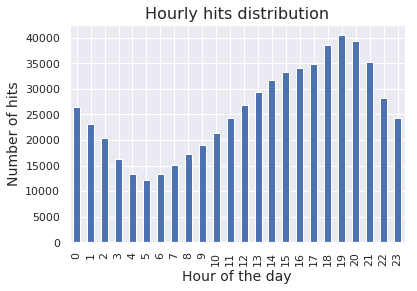

In [22]:
# Time of the day
train_data.groupby('hour_of_day')['hits'].count().plot(kind='bar')
plt.title('Hourly hits distribution', fontsize = 16)
plt.xlabel('Hour of the day', fontsize = 14)
plt.ylabel('Number of hits', fontsize = 14)

The pattern is quite expected and should also be used for feature engineering.

Text(0, 0.5, 'Number of hits')

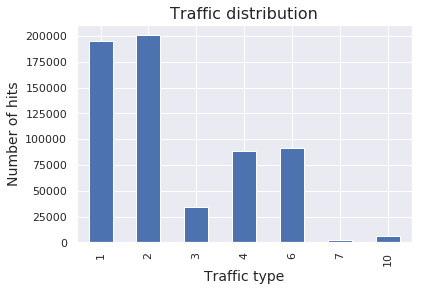

In [23]:
# Traffic type
train_data.groupby('traffic_type')['hits'].count().plot(kind='bar')
plt.title('Traffic distribution', fontsize = 16)
plt.xlabel('Traffic type', fontsize = 14)
plt.ylabel('Number of hits', fontsize = 14)

Looks like channels 1 and 2 generate the majority amount of hits for our webpage. We will think later what can be done with this information.

Now let us have a look at the distribution of the target vector.
Since we treat our problem as regression one, we need to check for the shape of our target, in order to choose the correct model. Because of the size of the dataset plotting takes quite some time, therefore let's randomly pick the subset of data and have a look at the distribution of targets of this subset.

Text(0, 0.5, 'Density')

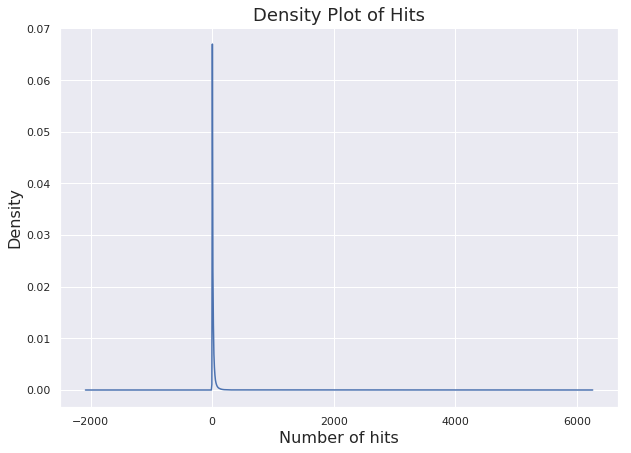

In [24]:
train_data['hits'].plot(kind = 'density', subplots = True,
                 sharex = False, figsize = (10,7))

plt.title('Density Plot of Hits', fontsize = 18)
plt.xlabel('Number of hits', fontsize = 16)
plt.ylabel('Density', fontsize = 16)

In the above plot, we see that the variable `hits` is prominently skewed right (its tail is longer on the right).

Text(0, 0.5, 'Features')

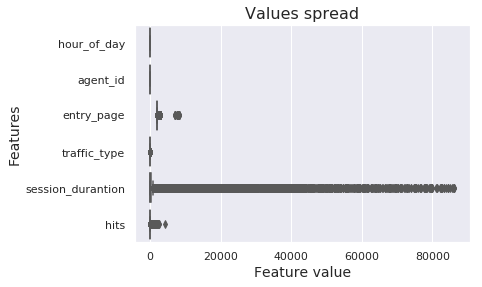

In [25]:
# Outliers. Let us check numerical features for outliers, we will do that with box plots

numerical_features = [col for col in train_data.columns if train_data[col].dtype != 'object']
plt.plot(figsize = (10,7))
sns.boxplot(data=train_data[numerical_features], orient="h", palette="Set2")
plt.title('Values spread', fontsize = 16)
plt.xlabel('Feature value', fontsize = 14)
plt.ylabel('Features', fontsize = 14)

Well, most of our numerical columns are in fact sort of categorical, therefore it made sense to observe the outliers within `hits` column, and it seems everything is fine here.

In [26]:
train_data.head(10)

,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id_set,traffic_type,session_durantion,hits
1,L2,Thursday,22,10,2113,31965;0,2,49,14
2,L4,Saturday,21,2,2100,0;78464,1,1892,14
3,L3,Saturday,19,8,2113,51462,6,0,1
4,L2,Tuesday,6,10,2116,31931;0,1,2,3
5,L3,Monday,1,8,2100,0,1,0,2
6,L2,Friday,20,10,2166,0,1,0,2
7,L3,Sunday,3,1,2113,34302;0,6,2,3
8,L3,Sunday,1,10,2111,34227;0,6,4,3
9,L6,Sunday,5,9,2113,42172;0;38715,2,724,45
10,L6,Wednesday,15,8,2100,0;45069;44232,1,896,39


### Feature Engineering

In [27]:
# Concatentate dataset first
train_length = len(train_data)
dataset =  pd.concat(objs=[train_data, test_data], axis=0).reset_index(drop=True)
dataset.head(10)

,agent_id,day_of_week,entry_page,hits,hour_of_day,locale,path_id_set,session_durantion,traffic_type
0,10,Thursday,2113,14.0,22,L2,31965;0,49,2
1,2,Saturday,2100,14.0,21,L4,0;78464,1892,1
2,8,Saturday,2113,1.0,19,L3,51462,0,6
3,10,Tuesday,2116,3.0,6,L2,31931;0,2,1
4,8,Monday,2100,2.0,1,L3,0,0,1
5,10,Friday,2166,2.0,20,L2,0,0,1
6,1,Sunday,2113,3.0,3,L3,34302;0,2,6
7,10,Sunday,2111,3.0,1,L3,34227;0,4,6
8,9,Sunday,2113,45.0,5,L6,42172;0;38715,724,2
9,8,Wednesday,2100,39.0,15,L6,0;45069;44232,896,1


We start with time, make it 2-dim in order to preserve cyclicity.

In [28]:
seconds_in_day = 24*60*60

dataset['sin_time'] = np.sin(2*np.pi*dataset.session_durantion/seconds_in_day)
dataset['cos_time'] = np.cos(2*np.pi*dataset.session_durantion/seconds_in_day)
dataset = dataset.drop('session_durantion', axis = 1)

dataset.head(10)

,agent_id,day_of_week,entry_page,hits,hour_of_day,locale,path_id_set,traffic_type,sin_time,cos_time
0,10,Thursday,2113,14.0,22,L2,31965;0,2,0.003563,0.999994
1,2,Saturday,2100,14.0,21,L4,0;78464,1,0.137156,0.990549
2,8,Saturday,2113,1.0,19,L3,51462,6,0.000000,1.000000
3,10,Tuesday,2116,3.0,6,L2,31931;0,1,0.000145,1.000000
4,8,Monday,2100,2.0,1,L3,0,1,0.000000,1.000000
5,10,Friday,2166,2.0,20,L2,0,1,0.000000,1.000000
6,1,Sunday,2113,3.0,3,L3,34302;0,6,0.000145,1.000000
7,10,Sunday,2111,3.0,1,L3,34227;0,6,0.000291,1.000000
8,9,Sunday,2113,45.0,5,L6,42172;0;38715,2,0.052626,0.998614
9,8,Wednesday,2100,39.0,15,L6,0;45069;44232,1,0.065113,0.997878


Furthermore, we saw that traffic type 1 and 2 got the majority of hits, let us encode this information.

In [29]:
# Important traffic (1 and 2)

dataset['hot_traffic'] = ((dataset['traffic_type'].isin([1,2]))).astype('int')
dataset['medium_traffic'] = ((dataset['traffic_type'].isin([4,6]))).astype('int')

dataset.head()

,agent_id,day_of_week,entry_page,hits,hour_of_day,locale,path_id_set,traffic_type,sin_time,cos_time,hot_traffic,medium_traffic
0,10,Thursday,2113,14.0,22,L2,31965;0,2,0.003563,0.999994,1,0
1,2,Saturday,2100,14.0,21,L4,0;78464,1,0.137156,0.990549,1,0
2,8,Saturday,2113,1.0,19,L3,51462,6,0.000000,1.000000,0,1
3,10,Tuesday,2116,3.0,6,L2,31931;0,1,0.000145,1.000000,1,0
4,8,Monday,2100,2.0,1,L3,0,1,0.000000,1.000000,1,0


Next step is to work a bit on `day_of_week` column. We start with defining 'hot' and 'low' days.

In [30]:
# Hot and Low days
dataset['day_high'] = ((dataset['day_of_week'].isin(['Monday', 'Sunday', 'Tuesday']))).astype('int')
dataset['day_low'] = ((dataset['day_of_week'].isin(['Friday', 'Saturday']))).astype('int')

dataset.head()

,agent_id,day_of_week,entry_page,hits,hour_of_day,locale,path_id_set,traffic_type,sin_time,cos_time,hot_traffic,medium_traffic,day_high,day_low
0,10,Thursday,2113,14.0,22,L2,31965;0,2,0.003563,0.999994,1,0,0,0
1,2,Saturday,2100,14.0,21,L4,0;78464,1,0.137156,0.990549,1,0,0,1
2,8,Saturday,2113,1.0,19,L3,51462,6,0.000000,1.000000,0,1,0,1
3,10,Tuesday,2116,3.0,6,L2,31931;0,1,0.000145,1.000000,1,0,1,0
4,8,Monday,2100,2.0,1,L3,0,1,0.000000,1.000000,1,0,1,0


Additionally lets simply dump the whole column.

In [31]:
dummy_dayOfWeek = pd.get_dummies(dataset['day_of_week'])
dataset = pd.concat([dataset, dummy_dayOfWeek], axis = 1)
dataset = dataset.drop('day_of_week', axis = 1)

dataset.head()

,agent_id,entry_page,hits,hour_of_day,locale,path_id_set,traffic_type,sin_time,cos_time,hot_traffic,medium_traffic,day_high,day_low,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,10,2113,14.0,22,L2,31965;0,2,0.003563,0.999994,1,0,0,0,0,0,0,0,1,0,0
1,2,2100,14.0,21,L4,0;78464,1,0.137156,0.990549,1,0,0,1,0,0,1,0,0,0,0
2,8,2113,1.0,19,L3,51462,6,0.000000,1.000000,0,1,0,1,0,0,1,0,0,0,0
3,10,2116,3.0,6,L2,31931;0,1,0.000145,1.000000,1,0,1,0,0,0,0,0,0,1,0
4,8,2100,2.0,1,L3,0,1,0.000000,1.000000,1,0,1,0,0,1,0,0,0,0,0


We also would generate a few more features from `hour_of_day`, namely: 

In [32]:
dataset['Morning'] = ((dataset['hour_of_day'] >= 6) & (dataset['hour_of_day'] < 12)).astype('int')
dataset['Day'] = ((dataset['hour_of_day'] >= 12) & (dataset['hour_of_day'] < 18)).astype('int')
dataset['Evening'] = ((dataset['hour_of_day'] >= 18) & (dataset['hour_of_day'] < 24)).astype('int')
dataset['Night'] = ((dataset['hour_of_day'] >= 0) & (dataset['hour_of_day'] < 6)).astype('int')

dataset.head()

,agent_id,entry_page,hits,hour_of_day,locale,path_id_set,traffic_type,sin_time,cos_time,hot_traffic,...,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Morning,Day,Evening,Night
0,10,2113,14.0,22,L2,31965;0,2,0.003563,0.999994,1,...,0,0,0,1,0,0,0,0,1,0
1,2,2100,14.0,21,L4,0;78464,1,0.137156,0.990549,1,...,0,1,0,0,0,0,0,0,1,0
2,8,2113,1.0,19,L3,51462,6,0.000000,1.000000,0,...,0,1,0,0,0,0,0,0,1,0
3,10,2116,3.0,6,L2,31931;0,1,0.000145,1.000000,1,...,0,0,0,0,1,0,1,0,0,0
4,8,2100,2.0,1,L3,0,1,0.000000,1.000000,1,...,1,0,0,0,0,0,0,0,0,1


There are a few more categorical columns, like `locale`, `agent_id`, `traffic_type`, `hour_of_day` and `entry_page` which also have to be converted into integer variables. The column `hour_of_day` is also has to be one-hot encoded. For now, we simply dump them as we did with `day_of_week`, however later, when we going to use **catBoost** these columns would be treated as categorical.

In [33]:
dataset = pd.get_dummies(data=dataset, columns=['agent_id', 'locale','traffic_type','hour_of_day','entry_page'])
dataset.head()

,hits,path_id_set,sin_time,cos_time,hot_traffic,medium_traffic,day_high,day_low,Friday,Monday,...,entry_page_2874,entry_page_2884,entry_page_2892,entry_page_6999,entry_page_8001,entry_page_8002,entry_page_8006,entry_page_8010,entry_page_8020,entry_page_8101
0,14.0,31965;0,0.003563,0.999994,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,14.0,0;78464,0.137156,0.990549,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,51462,0.000000,1.000000,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.0,31931;0,0.000145,1.000000,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2.0,0,0.000000,1.000000,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Now the most exciting part, namely to get some insights from `path_id_set` column. We could simply ommit it for the sake of simplicity, but we will try to expand it based on `;` delimiter.

In [34]:
dataset['path_id_set'].str.split(';', expand=True).head(5)

,0,1,2,3,4,5,6,7,8,9,...,123,124,125,126,127,128,129,130,131,132
0,31965,0,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,0,78464,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,51462,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,31931,0,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,0,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


Well, that doest not seem to have a lot of sence for now, lets wait till we apply CatBoost. For now lets just ommit this column. Also lets dummy `entry_page`.

In [35]:
dataset = dataset.drop('path_id_set', axis = 1)
dataset.head()

,hits,sin_time,cos_time,hot_traffic,medium_traffic,day_high,day_low,Friday,Monday,Saturday,...,entry_page_2874,entry_page_2884,entry_page_2892,entry_page_6999,entry_page_8001,entry_page_8002,entry_page_8006,entry_page_8010,entry_page_8020,entry_page_8101
0,14.0,0.003563,0.999994,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,14.0,0.137156,0.990549,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1.0,0.000000,1.000000,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,3.0,0.000145,1.000000,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2.0,0.000000,1.000000,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


So now we are ready to test baseline regression algorithms.

### Modeling

In [36]:
# Organize again train and test sets.
train_data = dataset[:train_length]
test_data = dataset[train_length:]

# Also need to drop 'hits' column in test
test_data = test_data.drop('hits', axis = 1)

# Create a target vector for training

Y = train_data['hits'].as_matrix()
X = train_data.drop('hits', axis = 1).as_matrix()

X_train, X_holdout, y_train, y_holdout = train_test_split(X, Y, test_size=0.25, 
                                                          random_state=17)

In [37]:
# Model Validation

n_folds = 5

def rmse_mae(model):
    
    kf = KFold(n_folds, shuffle=True, random_state=17).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    mae = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_absolute_error", cv = kf))
    
    return rmse,mae

In [38]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

Ridge = make_pipeline(RobustScaler(), Ridge(alpha =0.0005, random_state=5))

ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
model_lgb = lgb.LGBMRegressor(objective='regression_l2',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [39]:
%%time

score_lasso_rmse,score_lasso_mae = rmse_mae(lasso)
score_ridge_rmse,score_ridge_mae = rmse_mae(Ridge)
score_enet_rmse,score_enet_mae = rmse_mae(ENet)
score_xgb_rmse,score_xgb_mae = rmse_mae(model_xgb)
score_lgb_rmse,score_lgb_mae = rmse_mae(model_lgb)

print("Lasso score RMSE: {:.4f} ({:.4f})\n".format(score_lasso_rmse.mean(), score_lasso_rmse.std()))
print("Ridge score RMSE: {:.4f} ({:.4f})\n".format(score_ridge_rmse.mean(), score_ridge_rmse.std()))
print("ElasticNet score RMSE: {:.4f} ({:.4f})\n".format(score_enet_rmse.mean(), score_enet_rmse.std()))
print("Xgboost score RMSE: {:.4f} ({:.4f})\n".format(score_xgb_rmse.mean(), score_xgb_rmse.std()))
print("LGBM score RMSE: {:.4f} ({:.4f})\n" .format(score_lgb_rmse.mean(), score_lgb_rmse.std()))

print("\nLasso score MAE: {:.4f} ({:.4f})\n".format(score_lasso_mae.mean(), score_lasso_mae.std()))
print("Ridge score MAE: {:.4f} ({:.4f})\n".format(score_ridge_mae.mean(), score_ridge_mae.std()))
print("ElasticNet score MAE: {:.4f} ({:.4f})\n".format(score_enet_mae.mean(), score_enet_mae.std()))
print("Xgboost score MAE: {:.4f} ({:.4f})\n".format(score_xgb_mae.mean(), score_xgb_mae.std()))
print("LGBM score MAE: {:.4f} ({:.4f})\n" .format(score_lgb_mae.mean(), score_lgb_mae.std()))


Lasso score RMSE: 34.8069 (1.4401)

Ridge score RMSE: 34.8114 (1.4370)

ElasticNet score RMSE: 34.8050 (1.4406)

Xgboost score RMSE: 33.3920 (1.4751)

LGBM score RMSE: 33.0694 (1.4725)


Lasso score MAE: 3.7109 (0.0128)

Ridge score MAE: 3.7113 (0.0127)

ElasticNet score MAE: 3.7107 (0.0128)

Xgboost score MAE: 3.3894 (0.0135)

LGBM score MAE: 3.3881 (0.0108)

CPU times: user 21h 26min 17s, sys: 1min 11s, total: 21h 27min 28s
Wall time: 3h 56min 6s


Looks like Boosting algorithms outperform a little bit classical approaches. Lets have a look at the perfomance on the validation set.

In [40]:
def rmse(y_pred,y_true):
    
    return np.sqrt(mean_squared_error(y_true,y_pred))
    
def regressions(model):
    
    model.fit(X_train,y_train)
    model_predict = model.predict(X_holdout)
    
    print('MAE : %f' % (mean_absolute_error(y_holdout, model_predict)))
    print('R2 : %f' % (r2_score(y_holdout, model_predict)))
    print('RMSE : %f' % (rmse(y_holdout, model_predict)))    

In [41]:
regressions(lasso)

MAE : 13.738453
R2 : 0.185966
RMSE : 36.333280


In [42]:
regressions(Ridge)

MAE : 13.740658
R2 : 0.185541
RMSE : 36.342755


In [43]:
regressions(ENet)

MAE : 13.738268
R2 : 0.185988
RMSE : 36.332777


In [44]:
regressions(model_xgb)

MAE : 11.472278
R2 : 0.249946
RMSE : 34.876232


In [45]:
regressions(model_lgb)

MAE : 11.435046
R2 : 0.254698
RMSE : 34.765563


Both results are pretty much similar, but still LightGBM is outperforming on both training and validation data. Lets have a look at **feature importance**

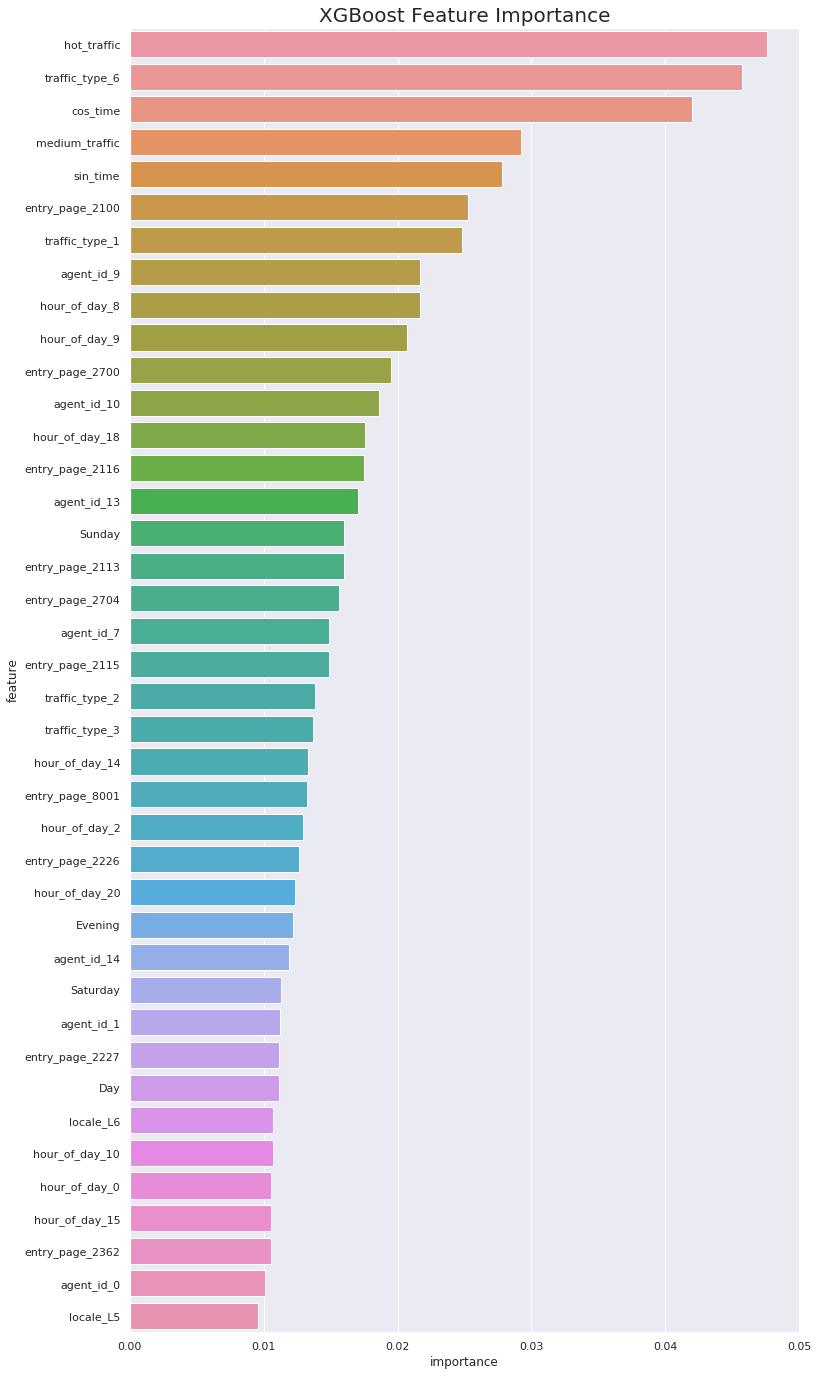

In [46]:
feature_importance_xgb = pd.DataFrame({'feature': train_data.drop('hits', axis = 1).columns, 'importance':model_xgb.feature_importances_}).sort_values('importance', ascending=False)[:40]

plt.figure(figsize=(12,24))
plt.title('XGBoost Feature Importance', fontsize=20)
sns.barplot(x=feature_importance_xgb.importance, y=feature_importance_xgb.feature);

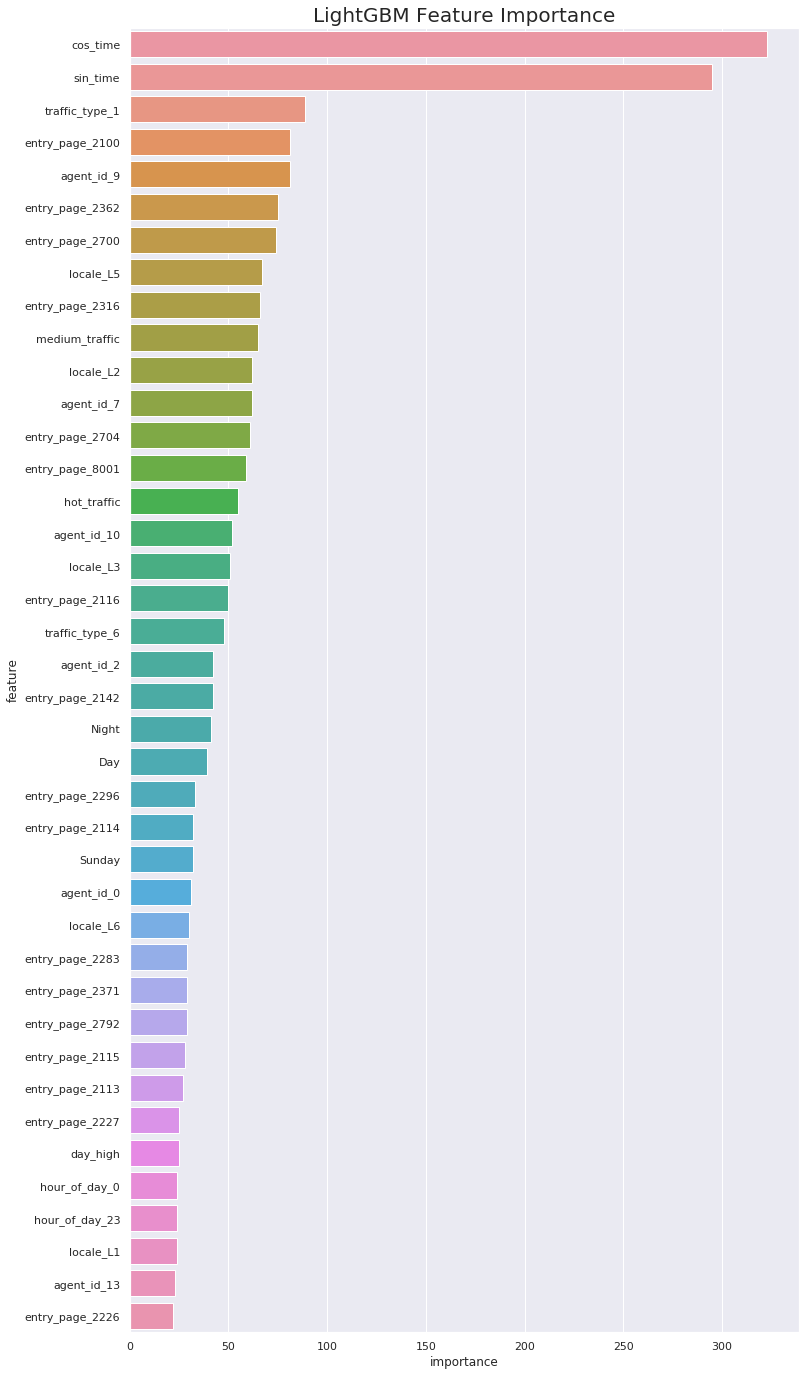

In [47]:
feature_importance_lgb = pd.DataFrame({'feature': train_data.drop('hits', axis = 1).columns, 'importance':model_lgb.feature_importances_}).sort_values('importance', ascending=False)[:40]

plt.figure(figsize=(12,24))
plt.title('LightGBM Feature Importance', fontsize=20)
sns.barplot(x=feature_importance_lgb.importance, y=feature_importance_lgb.feature);

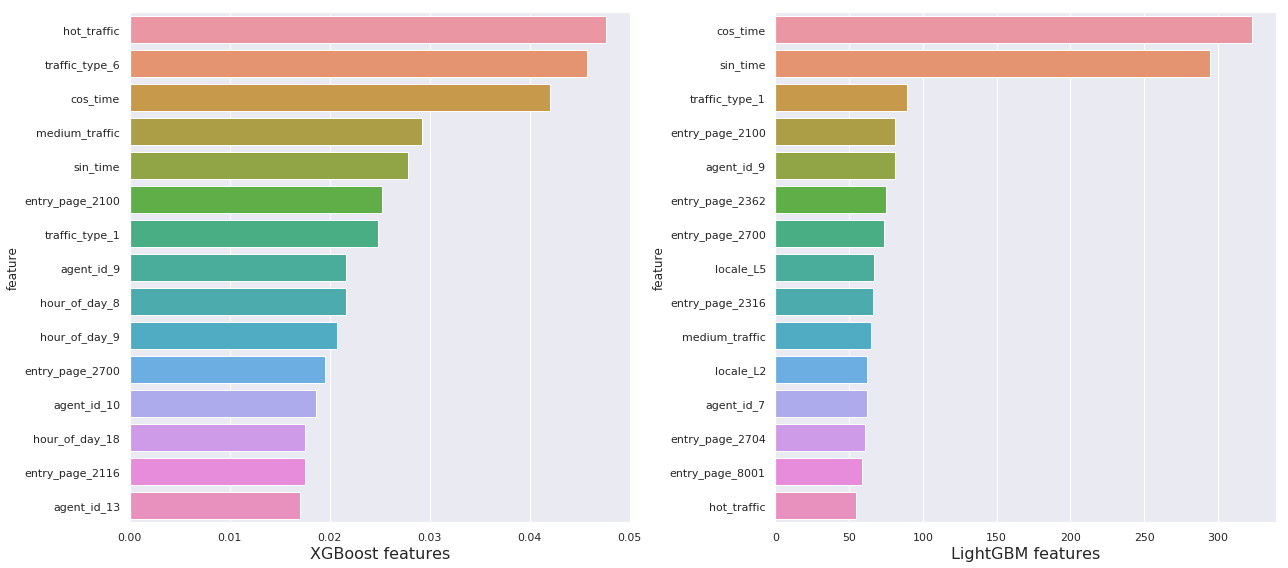

In [48]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
sns.barplot(x=feature_importance_xgb.importance[:15], y=feature_importance_xgb.feature[:15], ax=ax[0]);
sns.barplot(x=feature_importance_lgb.importance[:15], y=feature_importance_lgb.feature[:15],ax=ax[1])
ax[0].set_xlabel('XGBoost features', fontsize=16)
ax[1].set_xlabel('LightGBM features', fontsize=16)
plt.tight_layout()
plt.show()

Top - 15 features seems to be more or less similar for both algorithms, but we need to analyze the results more.

Continue with the predictions from LightGBM and lets have a look at residuals.
We will regress y on x (possibly as a robust or polynomial regression) and then draw a scatterplot of the residuals. 

Text(0, 0.5, 'Target Amount of hits')

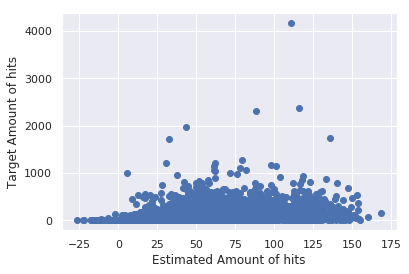

In [49]:
lightGbm_prediction = model_lgb.predict(X_holdout)

plt.scatter(lightGbm_prediction,y_holdout)
plt.xlabel("Estimated Amount of hits")
plt.ylabel("Target Amount of hits")

Seems like my residuals are unbalanced in Y-axis, this might be the result of skeweness of the target vector. In order to check that lets log-transform `hits` columns.

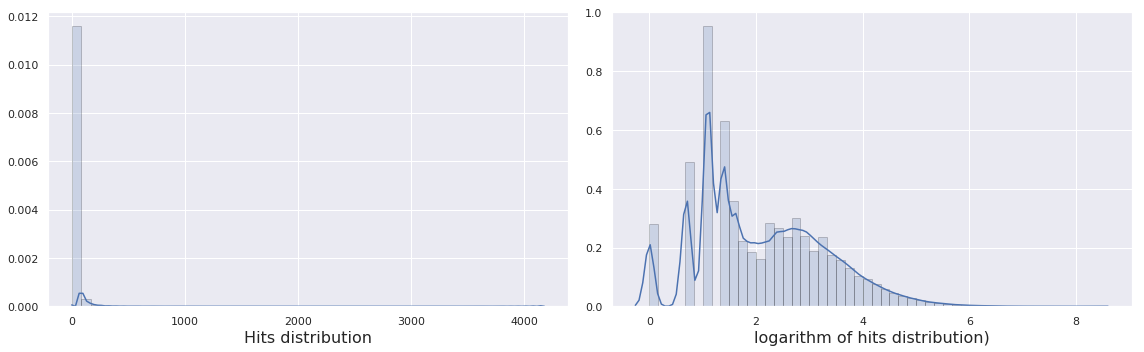

In [50]:
# Distribution of Hits
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
sns.distplot(train_data['hits'], ax=ax[0], hist_kws=hist_kws)
sns.distplot(np.log(train_data['hits']), ax=ax[1], hist_kws=hist_kws)
ax[0].set_xlabel('Hits distribution', fontsize=16)
ax[1].set_xlabel('logarithm of hits distribution)', fontsize=16)
plt.tight_layout()
plt.show()

In the above plot, we see that the hits count is prominently skewed right. The log transform looks more normal (left picture). In fact, for the data that has Poisson distribution, it is more appropriate to use **Anscombe transformation**. But I will skip it here. Let us log-transform target vector and repeat the procedure again. We will not be able to detect any improvements in *MAE* and *RMSE*, but in $R^{2}$.

In [51]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, Y, test_size=0.25, 
                                                          random_state=17)

y_train = np.log(y_train)
y_holdout = np.log(y_holdout)

In [52]:
score_lasso_rmse,score_lasso_mae = rmse_mae(lasso)
score_ridge_rmse,score_ridge_mae = rmse_mae(Ridge)
score_enet_rmse,score_enet_mae = rmse_mae(ENet)
score_xgb_rmse,score_xgb_mae = rmse_mae(model_xgb)
score_lgb_rmse,score_lgb_mae = rmse_mae(model_lgb)

print("Lasso score RMSE: {:.4f} ({:.4f})\n".format(score_lasso_rmse.mean(), score_lasso_rmse.std()))
print("Ridge score RMSE: {:.4f} ({:.4f})\n".format(score_ridge_rmse.mean(), score_ridge_rmse.std()))
print("ElasticNet score RMSE: {:.4f} ({:.4f})\n".format(score_enet_rmse.mean(), score_enet_rmse.std()))
print("Xgboost score RMSE: {:.4f} ({:.4f})\n".format(score_xgb_rmse.mean(), score_xgb_rmse.std()))
print("LGBM score RMSE: {:.4f} ({:.4f})\n" .format(score_lgb_rmse.mean(), score_lgb_rmse.std()))

print("\nLasso score MAE: {:.4f} ({:.4f})\n".format(score_lasso_mae.mean(), score_lasso_mae.std()))
print("Ridge score MAE: {:.4f} ({:.4f})\n".format(score_ridge_mae.mean(), score_ridge_mae.std()))
print("ElasticNet score MAE: {:.4f} ({:.4f})\n".format(score_enet_mae.mean(), score_enet_mae.std()))
print("Xgboost score MAE: {:.4f} ({:.4f})\n".format(score_xgb_mae.mean(), score_xgb_mae.std()))
print("LGBM score MAE: {:.4f} ({:.4f})\n" .format(score_lgb_mae.mean(), score_lgb_mae.std()))

Lasso score RMSE: 0.9164 (0.0040)

Ridge score RMSE: 0.9132 (0.0040)

ElasticNet score RMSE: 0.9162 (0.0040)

Xgboost score RMSE: 0.5674 (0.0020)

LGBM score RMSE: 0.5754 (0.0022)


Lasso score MAE: 0.8291 (0.0014)

Ridge score MAE: 0.8270 (0.0014)

ElasticNet score MAE: 0.8291 (0.0015)

Xgboost score MAE: 0.6277 (0.0012)

LGBM score MAE: 0.6340 (0.0011)



In [53]:
regressions(lasso)

MAE : 0.684338
R2 : 0.407511
RMSE : 0.911232


In [54]:
regressions(Ridge)

MAE : 0.680918
R2 : 0.411503
RMSE : 0.908157


In [55]:
regressions(ENet)

MAE : 0.684224
R2 : 0.407758
RMSE : 0.911041


In [56]:
regressions(model_xgb)

MAE : 0.393151
R2 : 0.771361
RMSE : 0.566062


In [57]:
regressions(model_lgb)

MAE : 0.400714
R2 : 0.764677
RMSE : 0.574276


The one can notice significant improvements in $R^{2}$ metric for all models: linear and boosting-based. This result advocate in favor of transforming the skewed variables, in this case, the target one.

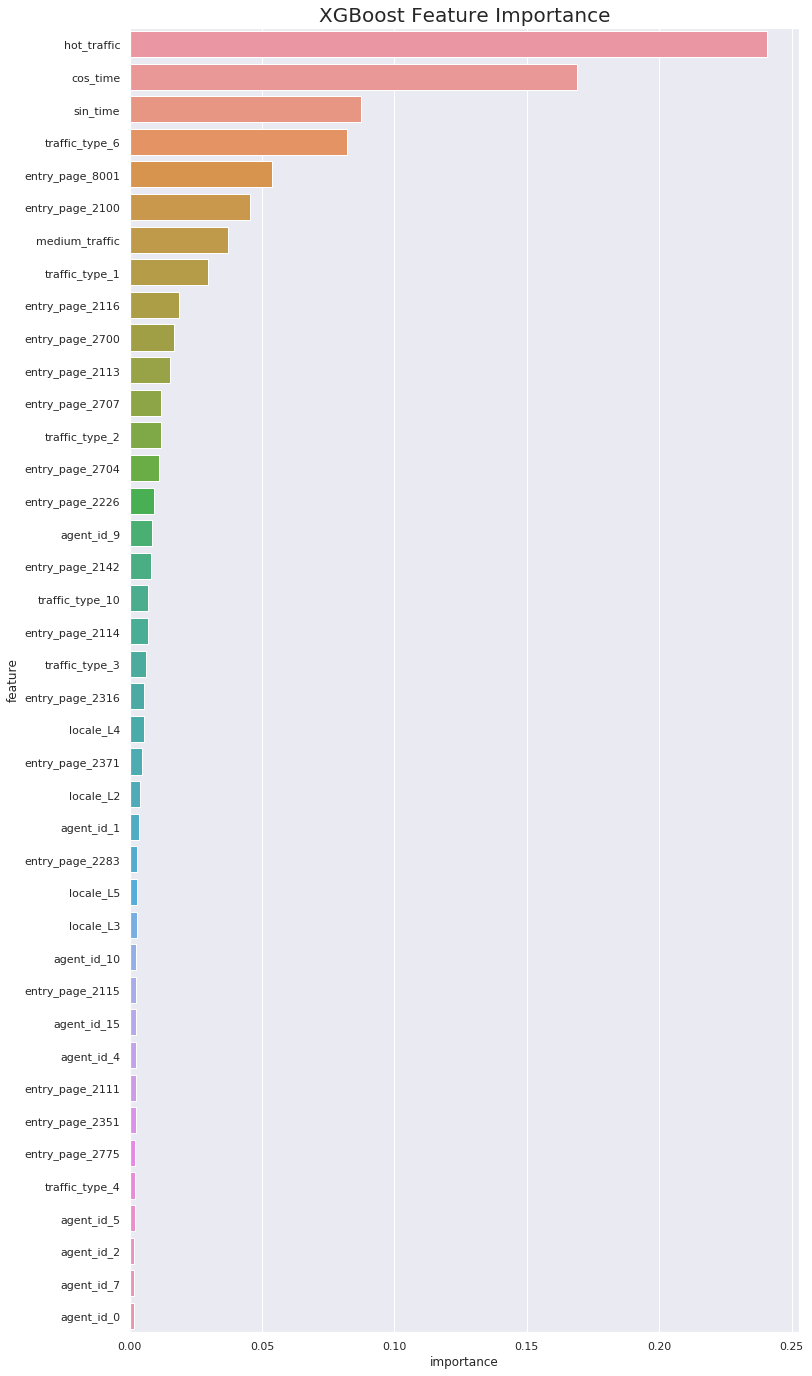

In [58]:
feature_importance_xgb = pd.DataFrame({'feature': train_data.drop('hits', axis = 1).columns, 'importance':model_xgb.feature_importances_}).sort_values('importance', ascending=False)[:40]

plt.figure(figsize=(12,24))
plt.title('XGBoost Feature Importance', fontsize=20)
sns.barplot(x=feature_importance_xgb.importance, y=feature_importance_xgb.feature);

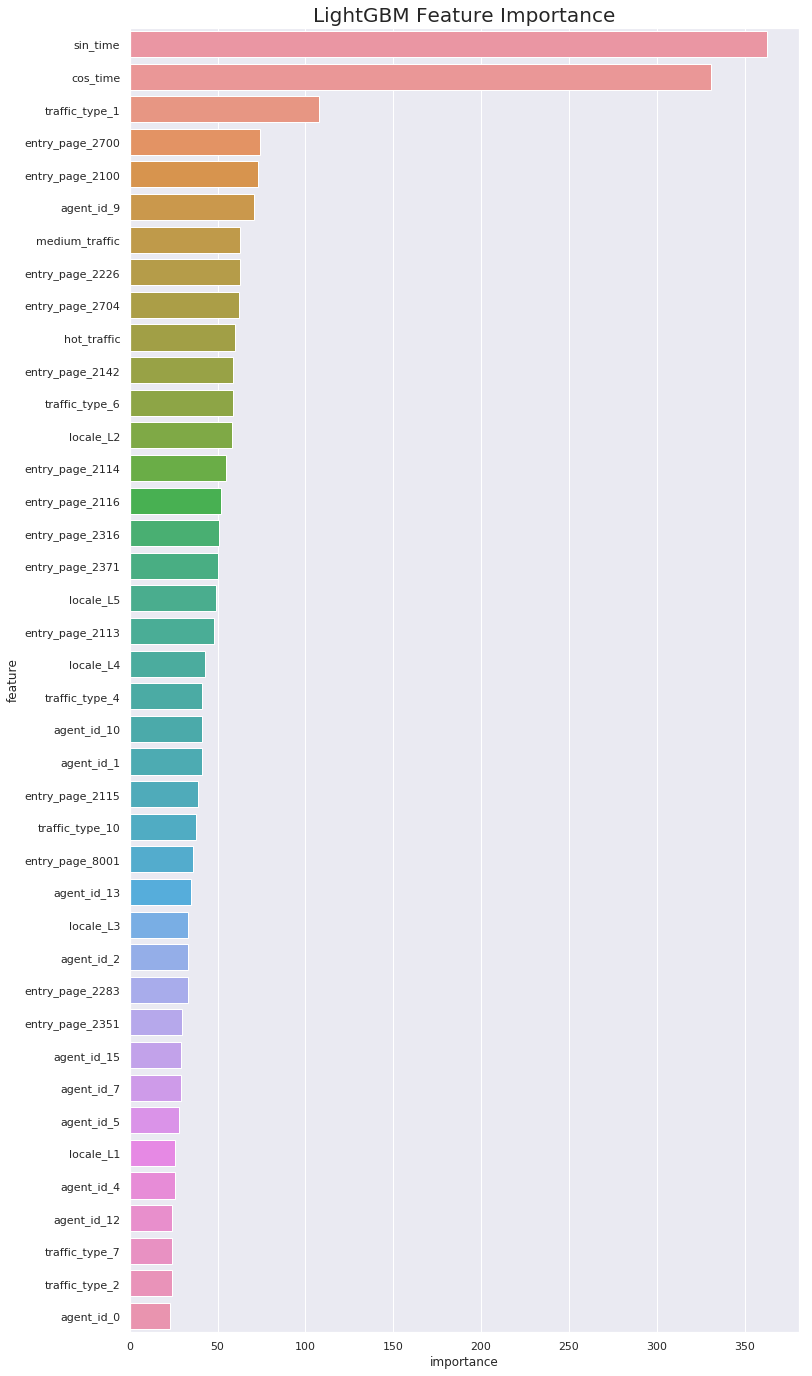

In [59]:
feature_importance_lgb = pd.DataFrame({'feature': train_data.drop('hits', axis = 1).columns, 'importance':model_lgb.feature_importances_}).sort_values('importance', ascending=False)[:40]

plt.figure(figsize=(12,24))
plt.title('LightGBM Feature Importance', fontsize=20)
sns.barplot(x=feature_importance_lgb.importance, y=feature_importance_lgb.feature);

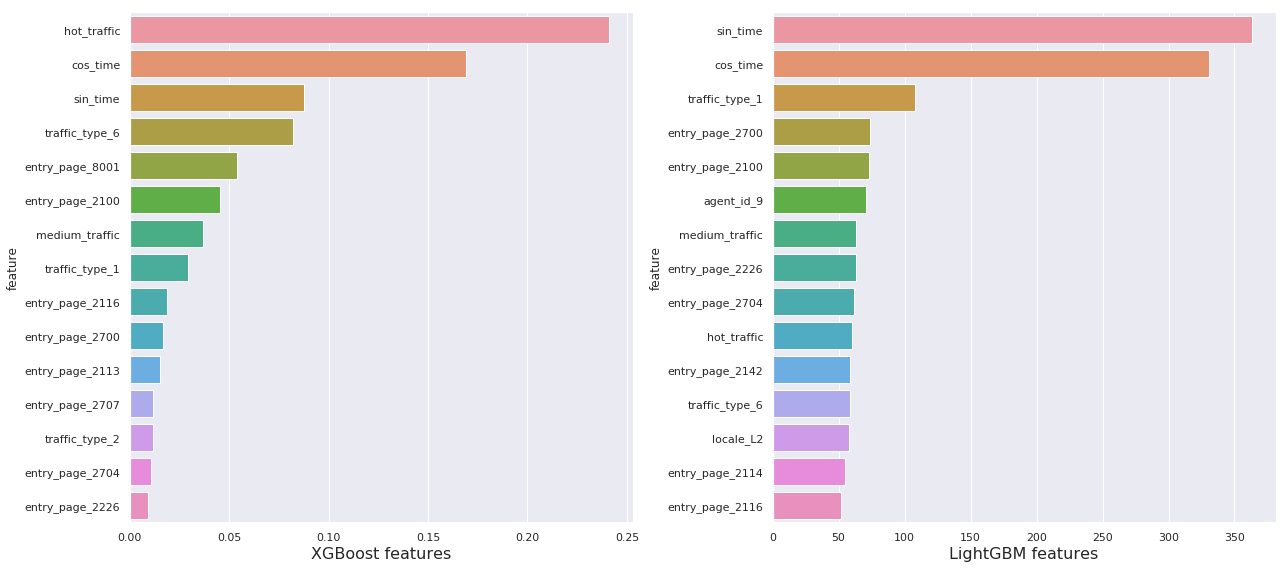

In [60]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
sns.barplot(x=feature_importance_xgb.importance[:15], y=feature_importance_xgb.feature[:15], ax=ax[0]);
sns.barplot(x=feature_importance_lgb.importance[:15], y=feature_importance_lgb.feature[:15],ax=ax[1])
ax[0].set_xlabel('XGBoost features', fontsize=16)
ax[1].set_xlabel('LightGBM features', fontsize=16)
plt.tight_layout()
plt.show()

Top - 15 features seems to be more or less similar for both algorithms, but we need to analyze the results more.

Continue with the predictions from LightGBM and lets have a look at residuals.
We will regress y on x (possibly as a robust or polynomial regression) and then draw a scatterplot of the residuals. 

Text(0, 0.5, 'Target Amount of hits')

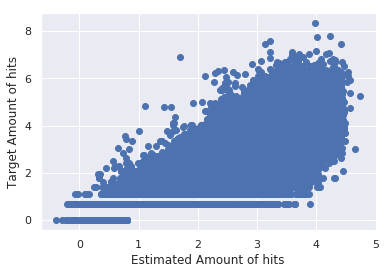

In [61]:
lightGbm_prediction = model_lgb.predict(X_holdout)

plt.scatter(lightGbm_prediction,y_holdout)
plt.xlabel("Estimated Amount of hits")
plt.ylabel("Target Amount of hits")

Now the residuals are more random than before.

Now lets create first submission file in order to have a baseline. Later we countinue with hyperparameters optimization for LightGBM and will start work on CatBoost.

In [62]:
test_data.head(10)

,sin_time,cos_time,hot_traffic,medium_traffic,day_high,day_low,Friday,Monday,Saturday,Sunday,...,entry_page_2874,entry_page_2884,entry_page_2892,entry_page_6999,entry_page_8001,entry_page_8002,entry_page_8006,entry_page_8010,entry_page_8020,entry_page_8101
618821,0.489700,0.871891,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
618822,0.368463,0.929643,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
618823,0.000364,1.000000,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
618824,0.551998,0.833846,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
618825,0.008508,0.999964,1,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
618826,0.005818,0.999983,1,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
618827,0.001891,0.999998,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
618828,0.124828,0.992178,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
618829,0.003200,0.999995,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
618830,0.108433,0.994104,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
hits_prediction = model_lgb.predict(test_data)


Hyperparameters optimization for LightGBM.

In [66]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, Y, test_size=0.25, 
                                                          random_state=17)

y_train = np.log(y_train)
y_holdout = np.log(y_holdout)

In [67]:
def lgb_eval(num_leaves,max_depth,lambda_l2,lambda_l1,min_child_samples, min_data_in_leaf):
    params = {
    "objective" : "regression",
    "metric" : "rmse", 
    "num_leaves" : int(num_leaves),
    "max_depth" : int(max_depth),
    "lambda_l2" : lambda_l2,
    "lambda_l1" : lambda_l1,
    "num_threads" : 20,
    "min_child_samples" : int(min_child_samples),
    'min_data_in_leaf': int(min_data_in_leaf),
    "learning_rate" : 0.03,
    "subsample_freq" : 5,
    "bagging_seed" : 42,
    "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(X, label=Y)
    cv_result = lgb.cv(params,
                       lgtrain,
                       num_boost_round=10000,
                       early_stopping_rounds=200,
                       stratified=True,
                       nfold=5)
    return cv_result['rmse-mean'][-1]

In [68]:
def lgb_train(num_leaves,max_depth,lambda_l2,lambda_l1,min_child_samples, min_data_in_leaf):
    params = {
    "objective" : "regression",
    "metric" : "rmse", 
    "num_leaves" : int(num_leaves),
    "max_depth" : int(max_depth),
    "lambda_l2" : lambda_l2,
    "lambda_l1" : lambda_l1,
    "num_threads" : 20,
    "min_child_samples" : int(min_child_samples),
    'min_data_in_leaf': int(min_data_in_leaf),
    "learning_rate" : 0.03,
    "subsample_freq" : 5,
    "bagging_seed" : 42,
    "verbosity" : -1
    }
    #X_train, X_holdout, y_train, y_holdout = train_test_split(X, Y, test_size=0.3, random_state=17)
    
    lgtrain = lgb.Dataset(X_train, label=y_train)
    lgvalid = lgb.Dataset(X_holdout, label=y_holdout)
    model = lgb.train(params, lgtrain, num_boost_round=20000, valid_sets=[lgvalid], early_stopping_rounds=400, verbose_eval=400)
    pred_test_y = model.predict(test_data, num_iteration=model.best_iteration)
    
    test_data_prediction = np.exp(hits_prediction)
    test_data_prediction = test_data_prediction.astype('int64')
    
    
    return pred_test_y, model

In [69]:
def param_tuning(init_points,num_iter,**args):
    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (15, 200),
                                                'max_depth': (5, 63),
                                                'lambda_l2': (0.0, 5),
                                                'lambda_l1': (0.0, 5),
                                                'min_child_samples': (50, 5000),
                                                'min_data_in_leaf': (50, 300)
                                                })

    lgbBO.maximize(init_points=init_points, n_iter=num_iter,**args)
    return lgbBO

In [70]:
%%time
result = param_tuning(10,50)

|   iter    |  target   | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_da... | num_le... |
-------------------------------------------------------------------------------------------------
|  1        |  31.89    |  3.172    |  1.55     |  37.31    |  2.809e+0 |  267.1    |  53.58    |
|  2        |  31.89    |  3.932    |  3.575    |  57.19    |  2.683e+0 |  175.2    |  116.7    |
|  3        |  31.89    |  3.024    |  1.884    |  10.04    |  1.67e+03 |  291.4    |  82.41    |
|  4        |  31.9     |  3.984    |  3.445    |  43.98    |  832.5    |  172.2    |  152.3    |
|  5        |  31.9     |  0.4218   |  1.609    |  24.9     |  3.182e+0 |  233.5    |  80.64    |
|  6        |  31.9     |  4.964    |  0.1966   |  5.342    |  3.892e+0 |  217.6    |  178.9    |
|  7        |  31.91    |  0.3033   |  2.14     |  33.41    |  398.2    |  82.91    |  190.8    |
|  8        |  31.89    |  4.665    |  1.093    |  23.28    |  176.4    |  161.1    |  129.5    |
|  9        |  31.91

|  51       |  31.92    |  2.418    |  0.4166   |  5.512    |  52.91    |  61.99    |  194.4    |
|  52       |  31.92    |  0.9329   |  2.52     |  7.023    |  1.817e+0 |  64.83    |  15.07    |
|  53       |  31.9     |  2.243    |  4.028    |  6.237    |  1.269e+0 |  299.7    |  195.4    |
|  54       |  31.93    |  1.816    |  4.103    |  5.187    |  2.665e+0 |  54.58    |  17.56    |
|  55       |  31.92    |  0.433    |  1.58     |  60.71    |  394.3    |  289.4    |  196.3    |
|  56       |  31.92    |  0.2122   |  3.493    |  62.73    |  2.904e+0 |  51.82    |  191.9    |
|  57       |  31.92    |  1.866    |  2.425    |  28.23    |  2.307e+0 |  51.09    |  198.3    |
|  58       |  31.89    |  3.615    |  2.251    |  8.762    |  2.116e+0 |  291.8    |  198.7    |
|  59       |  31.9     |  0.1537   |  4.474    |  12.25    |  4.655e+0 |  297.9    |  17.32    |
|  60       |  31.92    |  1.703    |  4.264    |  60.44    |  4.2e+03  |  298.0    |  183.8    |
CPU times: user 3h 4

In [71]:
params = result.max['params']
params

{'lambda_l1': 1.7560798829926934,
 'lambda_l2': 3.3510433324554283,
 'max_depth': 60.24583549341034,
 'min_child_samples': 432.9328838872184,
 'min_data_in_leaf': 50.43172081861368,
 'num_leaves': 15.110460037871572}

In [72]:
%%time
pred_test_y1, _ = lgb_train(**params)
pred_test_y2, _ = lgb_train(**params)
pred_test_y3, model = lgb_train(**params)
y_pred = (pred_test_y1 + pred_test_y2 + pred_test_y3)/3

Training until validation scores don't improve for 400 rounds.
[400]	valid_0's rmse: 0.567659
[800]	valid_0's rmse: 0.56514
[1200]	valid_0's rmse: 0.563946
[1600]	valid_0's rmse: 0.56327
[2000]	valid_0's rmse: 0.562639
[2400]	valid_0's rmse: 0.562296
[2800]	valid_0's rmse: 0.562172
[3200]	valid_0's rmse: 0.562085
[3600]	valid_0's rmse: 0.562049
Early stopping, best iteration is:
[3377]	valid_0's rmse: 0.562032
Training until validation scores don't improve for 400 rounds.
[400]	valid_0's rmse: 0.567659
[800]	valid_0's rmse: 0.56514
[1200]	valid_0's rmse: 0.563946
[1600]	valid_0's rmse: 0.56327
[2000]	valid_0's rmse: 0.562639
[2400]	valid_0's rmse: 0.562296
[2800]	valid_0's rmse: 0.562172
[3200]	valid_0's rmse: 0.562085
[3600]	valid_0's rmse: 0.562049
Early stopping, best iteration is:
[3377]	valid_0's rmse: 0.562032
Training until validation scores don't improve for 400 rounds.
[400]	valid_0's rmse: 0.567659
[800]	valid_0's rmse: 0.56514
[1200]	valid_0's rmse: 0.563946
[1600]	valid_0's

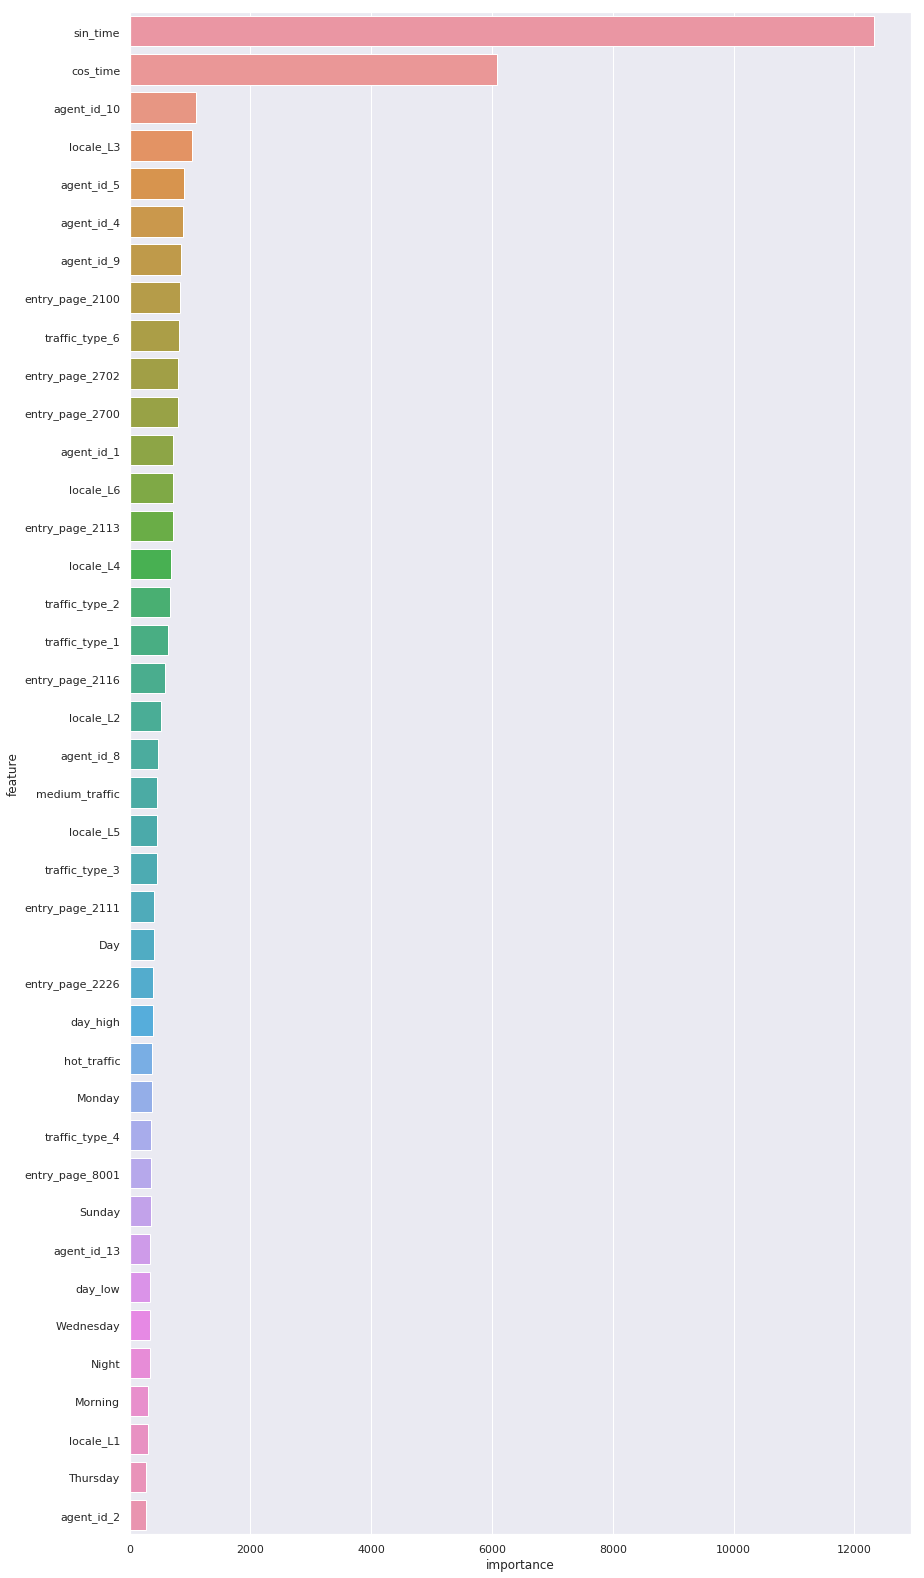

In [73]:
feature_importance = pd.DataFrame({'feature': train_data.drop('hits', axis = 1).columns, 'importance':model.feature_importance()}).sort_values('importance', ascending=False)[:40]

plt.figure(figsize=(14,28))
sns.barplot(x=feature_importance.importance, y=feature_importance.feature);

## CatBoost

Since the majority of our features are categorical, it would make sense to use CatBoost which proven to be working decently. However, I have one concern, is that CatBoost outperformed other boosting techniques working with categorical features on the datasets were there very a lot of this kind of feature. In our case, it is only a few, so let see.

In [80]:
import catboost
from catboost import CatBoostRegressor

In [82]:
data_cat.isnull().sum()

row_num                 0
locale                  0
day_of_week             0
hour_of_day             0
agent_id                0
entry_page              0
path_id_set          4889
traffic_type            0
session_durantion       0
hits                    0
dtype: int64

CatBoost knows how to deal with missing numbers, but for now we will just drop them

In [92]:
data_cat = data_cat.dropna()
data_cat.shape

(983124, 10)

In [93]:
seconds_in_day = 24*60*60

# Start with session duration and transform from object to int
data_cat.session_durantion =  data_cat.session_durantion.astype(int)
data_cat['sin_time'] = np.sin(2*np.pi*data_cat.session_durantion/seconds_in_day)
data_cat['cos_time'] = np.cos(2*np.pi*data_cat.session_durantion/seconds_in_day)
data_cat = data_cat.drop('session_durantion', axis = 1)

data_cat.head(10)

,row_num,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id_set,traffic_type,hits,sin_time,cos_time
0,988681,L6,Monday,17,1,2111,31672;0,6,\N,0.489700,0.871891
1,988680,L2,Thursday,22,10,2113,31965;0,2,14,0.003563,0.999994
2,988679,L4,Saturday,21,2,2100,0;78464,1,14,0.137156,0.990549
3,988678,L3,Saturday,19,8,2113,51462,6,1,0.000000,1.000000
4,988677,L2,Tuesday,6,10,2116,31931;0,1,3,0.000145,1.000000
5,988676,L3,Monday,1,8,2100,0,1,2,0.000000,1.000000
6,988675,L2,Friday,20,10,2166,0,1,2,0.000000,1.000000
7,988674,L3,Sunday,3,1,2113,34302;0,6,3,0.000145,1.000000
8,988673,L3,Sunday,1,10,2111,34227;0,6,3,0.000291,1.000000
9,988672,L6,Sunday,5,9,2113,42172;0;38715,2,45,0.052626,0.998614


In [94]:
mask_cat = data_cat['hits'] == '\\N'
train_data_cat = data_cat[~mask]
test_data_cat = data_cat[mask]

In [95]:
train_data_cat = train_data_cat.drop('row_num', axis = 1)
row_number_test_cat = test_data_cat['row_num']
test_data_cat = test_data_cat.drop('row_num', axis = 1)

train_data_cat.hits = train_data_cat.hits.astype('int64')

In [96]:
# Also need to drop 'hits' column in test
test_data = test_data_cat.drop('hits', axis = 1)

# Create a target vector for training
Y = train_data_cat['hits']
X = train_data_cat.drop('hits', axis = 1)

seed = 17
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.3, random_state=seed)

In [97]:
cat_features_names = ['locale', 'day_of_week', 'hour_of_day', 'agent_id', 'entry_page', 'path_id_set', 'traffic_type']
cat_features = [X.columns.get_loc(col) for col in cat_features_names]
print(cat_features)

[0, 1, 2, 3, 4, 5, 6]


In [98]:
%%time

params = {'iterations': 2500,
          'loss_function':'RMSE',
          'eval_metric':'RMSE',
          'cat_features': cat_features,
          'task_type': 'GPU',
          'border_count': 32,
          'verbose': 100,
          'early_stopping_rounds': 500,
          'random_seed': seed
         }
cbc = CatBoostRegressor(**params)
cbc.fit(X_train, y_train,
          eval_set=(X_valid, y_valid),
          use_best_model=True,
          plot=True
         );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 42.5959689	test: 43.1364486	best: 43.1364486 (0)	total: 29.1ms	remaining: 1m 12s
100:	learn: 32.9572690	test: 33.5387183	best: 33.5387183 (100)	total: 2.91s	remaining: 1m 9s
200:	learn: 32.6584711	test: 33.3128780	best: 33.3128780 (200)	total: 5.72s	remaining: 1m 5s
300:	learn: 32.4865555	test: 33.2451835	best: 33.2451835 (300)	total: 8.5s	remaining: 1m 2s
400:	learn: 32.3552561	test: 33.2137075	best: 33.2136358 (399)	total: 11.2s	remaining: 58.9s
500:	learn: 32.2444816	test: 33.2002180	best: 33.2002180 (500)	total: 14s	remaining: 55.7s
600:	learn: 32.1367854	test: 33.1782059	best: 33.1768952 (590)	total: 16.7s	remaining: 52.7s
700:	learn: 32.0599774	test: 33.1653001	best: 33.1643141 (682)	total: 19.4s	remaining: 49.9s
800:	learn: 31.9799992	test: 33.1537232	best: 33.1537232 (800)	total: 22.2s	remaining: 47.1s
900:	learn: 31.9067014	test: 33.1485414	best: 33.1485140 (899)	total: 24.9s	remaining: 44.2s
1000:	learn: 31.8279361	test: 33.1389062	best: 33.1389062 (1000)	total: 27.

Create the resulting table.

In [102]:
results = pd.DataFrame({'Algorithm': ['Lasso', 'Ridge','Enet','Xgb','LightGBM', 'Catboost'], 'RMSE on valid.set':[36.33,36.34,36.33,34.87,34.76,33.12]})
results

,Algorithm,RMSE on valid.set
0,Lasso,36.33
1,Ridge,36.34
2,Enet,36.33
3,Xgb,34.87
4,LightGBM,34.76
5,Catboost,33.12


**Conclusion**: The one may see at the comparison table that Catboost outperformed all other algorithms, taking way less training time. This results can further be improved by optimizing hyperparameters. Overall in this tutorial, the basic EDA and Feature Engineering were demonstrated. Additionally, was shown that performing logarithm or box-cox transformation will improve the prediction capabilities of a model. 